In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Dropout, Activation, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import categorical_accuracy, Precision, Recall, TopKCategoricalAccuracy
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.applications import MobileNetV3Large
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight

2024-11-12 20:43:38.729847: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 20:43:38.750638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731462218.771745  264751 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731462218.778144  264751 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 20:43:38.800042: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
print("TensorFlow version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices('GPU')) 

TensorFlow version: 2.18.0
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:8', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:9', device_type='GPU')]


In [3]:
current_path = os.getcwd()
train_dir = current_path + '/ISIC2019Dataset/data/train/'
val_dir = current_path + '/ISIC2019Dataset/data/val/'
test_dir = current_path + '/ISIC2019Dataset/ISIC_2019_test_dir/'
training_directory_path = '/ISIC2019Dataset/ISIC_2019_Training_Input/'
training_metadata_path = '/ISIC2019Dataset/ISIC_2019_Training_Metadata.csv'
ground_truth_path = '/ISIC2019Dataset/ISIC_2019_Training_GroundTruth.csv'
test_directory_path = '/ISIC2019Dataset/ISIC_2019_Test_Input/'
test_metadata_path = '/ISIC2019Dataset/ISIC_2019_Test_Metadata.csv'

training_metadata_table = pd.read_csv(current_path + training_metadata_path)
test_metadata_table = pd.read_csv(current_path + test_metadata_path)
ground_truth_table = pd.read_csv(current_path + ground_truth_path)

In [4]:
training_metadata_table

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male
...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female


LABELS

- MEL - Melanoma
- NV - Melanocytic nevus
- BCC - Basal cell carcinoma
- AK - Actinic keratosis
- BKL - Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
- DF - Dermatofibroma
- VASC - Vascular lesion
- SCC - Squamous cell carcinoma
- UNK - None of the above

In [5]:
training_metadata_table['age_approx'].fillna((training_metadata_table['age_approx'].mean()), inplace=True)
training_metadata_table.dropna(subset=['anatom_site_general', 'lesion_id', 'sex'], inplace=True)
training_metadata_table.isnull().sum()

/tmp/ipykernel_264751/174194398.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  training_metadata_table['age_approx'].fillna((training_metadata_table['age_approx'].mean()), inplace=True)


image                  0
age_approx             0
anatom_site_general    0
lesion_id              0
sex                    0
dtype: int64

In [6]:
classes=['NV','BCC','AK','BKL','DF','VASC','SCC','MEL']

ground_truth_table['label'] = ground_truth_table[classes].idxmax(axis=1)
ground_truth_table.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,label
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL


In [7]:

# for c in classes:
#     # folders inside train_dir
#     class_train_dir = os.path.join(data_dir, c)
#     if not os.path.exists(class_train_dir):
#         os.mkdir(class_train_dir)

#     # folders inside val_dir
#     class_val_dir = os.path.join(data_dir, c)
#     if not os.path.exists(class_val_dir):
#         os.mkdir(class_val_dir)

In [8]:
# ground_truth_table.set_index('image', inplace=True)
# folder = os.listdir(current_path + training_directory_path)
# image_list = list(ground_truth_table.index)

# for image in image_list:
    
#     fname = image + '.jpg'
#     label = ground_truth_table.loc[image,'label']
    
#     if fname in folder:
#         src = os.path.join(current_path + training_directory_path, fname)
#         dst = os.path.join(data_dir, label, fname)
#         shutil.copyfile(src, dst)

In [9]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split

# # Define dataset paths
# data_dir = '/home/fall2019/qnd5128/capstone/SkinLesionClassification/ISIC2019Dataset/ISIC_2019_data_dir'
# base_dir = '/home/fall2019/qnd5128/capstone/SkinLesionClassification/ISIC2019Dataset/data'
# train_dir = os.path.join(base_dir, 'train')
# val_dir = os.path.join(base_dir, 'val')

# # Print paths for confirmation
# print("Base directory for split data:", base_dir)
# print("Original data directory:", data_dir)

# # Create directories for training and validation
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)

# # Get all classes (folders) in the original dataset directory
# classes = os.listdir(data_dir)

# # Split the data and organize into folders
# for class_name in classes:
#     # Create class-specific directories in train and validation folders
#     os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
#     os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    
#     # List all images in each class folder
#     images = os.listdir(os.path.join(data_dir, class_name))
#     images = [os.path.join(data_dir, class_name, img) for img in images]
    
#     # Split images into train and validation sets (e.g., 85% train, 15% validation)
#     train_images, val_images = train_test_split(images, test_size=0.15, random_state=42)
    
#     # Move images to the train directory
#     for img in train_images:
#         shutil.copy(img, os.path.join(train_dir, class_name))
    
#     # Move images to the validation directory
#     for img in val_images:
#         shutil.copy(img, os.path.join(val_dir, class_name))

# print("Data split into training and validation directories successfully.")


## Train Test Split & Data Augmentation

In [10]:
target_size = (224,224)
image_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

train_batches = image_gen.flow_from_directory(train_dir,
                                              target_size=target_size,
                                              color_mode='rgb',
                                              batch_size=32,
                                              class_mode='categorical')

val_batches = image_gen.flow_from_directory(val_dir,
                                            target_size=target_size,
                                            color_mode='rgb',
                                            batch_size=32,
                                            class_mode='categorical',
                                            shuffle=False)

print(train_batches.class_indices)

Found 21527 images belonging to 8 classes.
Found 3804 images belonging to 8 classes.
{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}


## Transfer Learning using ResNet50 Model

In [11]:
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-40]:  
    layer.trainable = False

x = base_model.output
x = Conv2D(1280, kernel_size=1, padding='same', use_bias=True, name='Conv_1')(x)
x = BatchNormalization()(x)
x = Activation('hard_swish', name='Conv_1_activation')(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(8, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()


W0000 00:00:1731462248.229219  264751 gpu_device.cc:2277] Unable to enable peer access between device ordinals 0 and 9, status: INTERNAL: failed to enable peer access from 0x55d740b50290 to 0x55d745e40e60: INTERNAL: CUDA error: : CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
W0000 00:00:1731462248.251318  264751 gpu_device.cc:2277] Unable to enable peer access between device ordinals 1 and 9, status: INTERNAL: failed to enable peer access from 0x55d741493ce0 to 0x55d745e40e60: INTERNAL: CUDA error: : CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
W0000 00:00:1731462248.280585  264751 gpu_device.cc:2277] Unable to enable peer access between device ordinals 2 and 9, status: INTERNAL: failed to enable peer access from 0x55d741da8c10 to 0x55d745e40e60: INTERNAL: CUDA error: : CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
W0000 00:00:1731462248.304016  264751 gpu_device.cc:2277] Unable to enable peer access between device ordinals 3 and 9, status: IN

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 4,241,800 (16.18 MB)

 Trainable params: 3,327,600 (12.69 MB)

 Non-trainable params: 914,200 (3.49 MB)

### Calculate Class Weights

In [12]:
label_to_index = train_batches.class_indices  

index_to_label = {v: k for k, v in label_to_index.items()}
ground_truth_table['label_index'] = ground_truth_table['label'].map(label_to_index)

classes = np.unique(ground_truth_table['label_index'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=ground_truth_table['label_index']
)

class_weights_dict = dict(zip(classes, class_weights))
class_weights_dict

{0: 3.652104959630911,
 1: 0.9528663857959675,
 2: 1.2066977896341464,
 3: 13.248430962343097,
 4: 0.7002156125608138,
 5: 0.24593203883495146,
 6: 5.041998407643312,
 7: 12.515316205533598}

### Training Model 

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.mixed_precision import set_global_policy

# Function to compute sample weights
def compute_sample_weights(labels, class_weights):
    sample_weights = np.array([class_weights[np.argmax(label)] for label in labels])
    return sample_weights

def generator_with_sample_weights(generator, class_weights):
    while True:
        x, y = next(generator)
        sample_weights = compute_sample_weights(y, class_weights)
        yield x, y, sample_weights


train_batches_with_weights = generator_with_sample_weights(train_batches, class_weights_dict)
valid_batches_with_weights = generator_with_sample_weights(val_batches, class_weights_dict)


model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=[categorical_accuracy, 
                       Precision(name='precision'), 
                       Recall(name='recall'), 
                       TopKCategoricalAccuracy(k=3, name='top_3_accuracy')])

checkpoint = ModelCheckpoint('mobilenetv3_checkpoint.keras', monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=10, verbose=1, mode='max', min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True, mode='max', verbose=1)

callbacks_list = [checkpoint, reduce_lr, early_stopping]

history = model.fit(
    train_batches_with_weights,
    validation_data=valid_batches_with_weights,
    steps_per_epoch=len(train_batches),
    validation_steps=len(val_batches),
    epochs=15,
    callbacks=callbacks_list
)

# Save the final model
model.save('mobilenetv3_full_model_after_training.keras')

Epoch 1/15
670/673 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step - categorical_accuracy: 0.4401 - loss: 1.6081 - precision: 0.7317 - recall: 0.1658 - top_3_accuracy: 0.7482

E0000 00:00:1731462747.360300  265195 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731462747.498526  265195 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731462747.636107  265195 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - categorical_accuracy: 0.4405 - loss: 1.6070 - precision: 0.7317 - recall: 0.1663 - top_3_accuracy: 0.7485
Epoch 1: val_categorical_accuracy improved from -inf to 0.63696, saving model to mobilenetv3_checkpoint.keras
673/673 ━━━━━━━━━━━━━━━━━━━━ 494s 710ms/step - categorical_accuracy: 0.4406 - loss: 1.6066 - precision: 0.7317 - recall: 0.1665 - top_3_accuracy: 0.7486 - val_categorical_accuracy: 0.6370 - val_loss: 1.1617 - val_precision: 0.7487 - val_recall: 0.5358 - val_top_3_accuracy: 0.8946 - learning_rate: 1.0000e-04
Epoch 2/15
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - categorical_accuracy: 0.6131 - loss: 0.9891 - precision: 0.7410 - recall: 0.4622 - top_3_accuracy: 0.8995
Epoch 2: val_categorical_accuracy improved from 0.63696 to 0.65379, saving model to mobilenetv3_checkpoint.keras
673/673 ━━━━━━━━━━━━━━━━━━━━ 463s 689ms/step - categorical_accuracy: 0.6131 - loss: 0.9891 - precision: 0.7410 - recall: 0.4622 - top_3_accuracy: 0.8995 - 

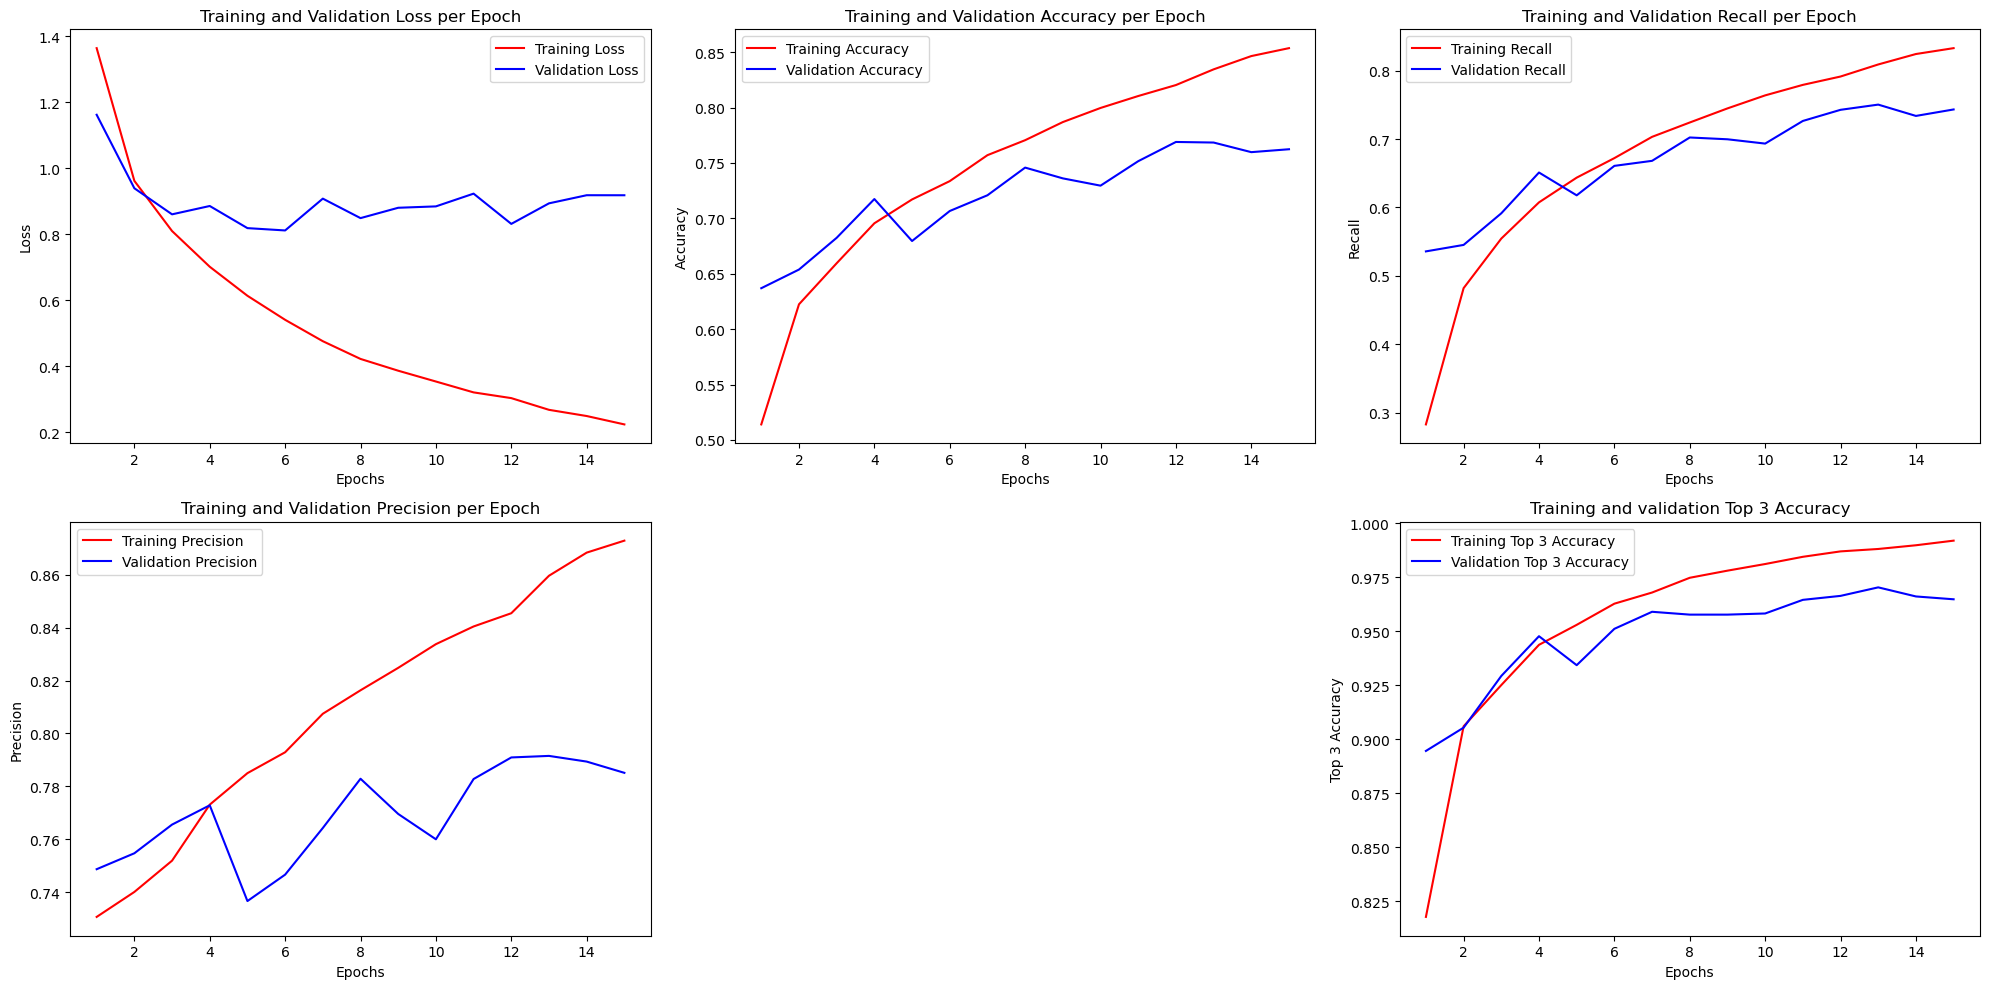

In [15]:
# Extract metrics from history for Resnet50
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
train_recall = history.history['recall']
val_recall = history.history['val_recall']
train_precision = history.history['precision']
val_precision = history.history['val_precision']
# train_f1 = history.history['f1_m']
# val_f1 = history.history['val_f1_m']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plot and save the metrics
plt.figure(figsize=(20, 10))

# Plot Loss
plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(current_path, 'mobilenetv3_training_validation_loss.png'))

# Plot Accuracy
plt.subplot(2, 3, 2)
plt.plot(epochs, train_acc, 'r-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(current_path, 'mobilenetv3_training_validation_accuracy.png'))

# Plot Recall
plt.subplot(2, 3, 3)
plt.plot(epochs, train_recall, 'r-', label='Training Recall')
plt.plot(epochs, val_recall, 'b-', label='Validation Recall')
plt.title('Training and Validation Recall per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.savefig(os.path.join(current_path, 'mobilenetv3_training_validation_recall.png'))

# Plot Precision
plt.subplot(2, 3, 4)
plt.plot(epochs, train_precision, 'r-', label='Training Precision')
plt.plot(epochs, val_precision, 'b-', label='Validation Precision')
plt.title('Training and Validation Precision per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.savefig(os.path.join(current_path, 'mobilenetv3_training_validation_precision.png'))

# Plot F1 Score
# plt.subplot(2, 3, 5)
# plt.plot(epochs, train_f1, 'r-', label='Training F1 Score')
# plt.plot(epochs, val_f1, 'b-', label='Validation F1 Score')
# plt.title('Training and Validation F1 Score per Epoch')
# plt.xlabel('Epochs')
# plt.ylabel('F1 Score')
# plt.legend()
# plt.savefig(os.path.join(current_path, 'resnet50_training_validation_f1_score.png'))

# Plot Top 3 Accuracy
plt.subplot(2, 3, 6)
plt.plot(epochs, train_top3_acc, 'r-', label='Training Top 3 Accuracy')
plt.plot(epochs, val_top3_acc, 'b-', label='Validation Top 3 Accuracy')
plt.title('Training and validation Top 3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top 3 Accuracy')
plt.legend()
plt.savefig(os.path.join(current_path, 'mobilenetv3_training_validation_top3_acc.png'))

plt.tight_layout()
plt.savefig(os.path.join(current_path, 'mobilenetv3_all_metrics_plots.png'))
plt.show()


In [16]:
for key, value in history.history.items():
    print(f"{key}: {len(value)}")


categorical_accuracy: 15
loss: 15
precision: 15
recall: 15
top_3_accuracy: 15
val_categorical_accuracy: 15
val_loss: 15
val_precision: 15
val_recall: 15
val_top_3_accuracy: 15
learning_rate: 15


In [17]:
model.evaluate(val_batches)

/home/fall2019/qnd5128/miniconda3/envs/capstone_env_/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


119/119 ━━━━━━━━━━━━━━━━━━━━ 76s 598ms/step - categorical_accuracy: 0.7563 - loss: 0.7854 - precision: 0.7812 - recall: 0.7310 - top_3_accuracy: 0.9584


[0.7188525199890137,
 0.7589379549026489,
 0.7851748466491699,
 0.7379074692726135,
 0.9658254384994507]

In [18]:
predictions = model.predict(val_batches, verbose=1)
predictions = predictions.argmax(axis=1)

test_labels = val_batches.classes

119/119 ━━━━━━━━━━━━━━━━━━━━ 77s 610ms/step


In [22]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(test_labels, predictions)
print(classification_report(val_batches.classes, predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.52      0.66      0.58       131
           1       0.70      0.82      0.76       499
           2       0.56      0.69      0.62       394
           3       0.42      0.78      0.55        36
           4       0.69      0.66      0.67       679
           5       0.91      0.80      0.85      1932
           6       0.54      0.63      0.58        95
           7       0.80      0.87      0.84        38

    accuracy                           0.76      3804
   macro avg       0.64      0.74      0.68      3804
weighted avg       0.78      0.76      0.76      3804



Confusion matrix, without normalization
[[  86   26    7    1    5    1    5    0]
 [  17  410   16    9   13   17   17    0]
 [  24   26  272    3   29   26   10    4]
 [   2    3    0   28    0    1    2    0]
 [  16   34   62    7  451  102    6    1]
 [  17   60  129   16  154 1541   12    3]
 [   3   22    4    1    5    0   60    0]
 [   0    2    0    1    1    1    0   33]]


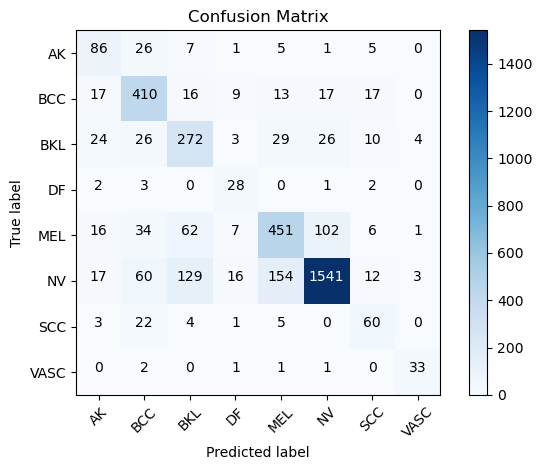

In [23]:
from sklearn import metrics
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

test_labels = val_batches.classes
cm_plot_labels = ['AK', 'BCC', 'BKL', 'DF', 'MEL','NV', 'SCC', 'VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')